# <b>Malaria Detection with AlexNet and VGG-16</b>

##<b>Problem Statement</b>

Malaria remains a significant global health challenge, particularly in regions with high transmission rates, such as sub-Saharan Africa, South Asia, and parts of Latin America. Despite ongoing efforts to combat the disease, malaria continues to cause a significant burden of illness and death worldwide. According to the World Health Organization (WHO), an estimated 231 million people were infected with malaria in 2021, resulting in approximately 409,000 deaths. Most malaria-related deaths occur in children under the age of five in sub-Saharan Africa, with pregnant women also at heightened risk. Malaria disproportionately affects vulnerable populations, including those living in poverty, conflict-affected areas, and remote or underserved communities with limited access to healthcare.


<b>The objectives:</b>

Lack of access to effective diagnostics and treatments is a main reason to hinder the control of malaria in many regions. <b>The key objective of this project is to build a machine learning model for classifying whether the image of a given red blood cell is infected with malaria or not, by using AlexNet and VGG16 architectures.</b> Looking into the result images of this classification problem, we can learn new insights about the visual distinction between infected and uninfected cells, to help better tackle malaria in ongoing research.

##<b>Data Description</b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


Parasitized: The parasitized cells contain the Plasmodium parasite which causes malaria<br>
Uninfected: The uninfected cells are free of the Plasmodium parasites<br>

**Data Source:**
National Library of Medicine (NLM)
https://ceb.nlm.nih.gov/repositories/malaria-datasets/

###<b>Mount the Drive</b>

In [ ]:
# Mounting the drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


### <b>Load libraries</b>

In [ ]:
!pip install keras_tuner
!pip install livelossplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 14.0 MB/s eta 0:00:00


In [ ]:
# Importing libraries
import zipfile
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras import Model

import keras_tuner

from livelossplot import PlotLossesKeras

Using TensorFlow backend


###<b>Load the data</b>

In [ ]:
# Load the data from drive
path = "/content/drive/MyDrive/MyProjects/cell_images.zip"

with zipfile.ZipFile(path, 'r') as zip_file:
  zip_file.extractall()

###<b>Data Labeling</b>

In [ ]:
# Specify the path for train folder
train_path = "/content/cell_images/train"
# Specify the path for test folder
test_path = "/content/cell_images/test"
# Specify folders
folders = ["/parasitized/", "/uninfected/"]

In [ ]:
# define function to convert images and labels
def getImagesLabels(folders, path):
  # declare empty list for storing images and labels
  images = []
  labels = []

  for folder in folders:
    images_path = os.listdir(path + folder)

    for i, image_name in enumerate(images_path):
      try:
        image = Image.open(path + folder + image_name)
        image = image.resize((64, 64))
        images.append(np.array(image))
        # create labels
        if folder == "/parasitized/":
          labels.append(1)
        else:
          labels.append(0)
      except Exception:
        pass

  return np.array(images), np.array(labels)

In [ ]:
# get the images and labels for train and test
train_images, train_labels = getImagesLabels(folders, train_path)
test_images, test_labels = getImagesLabels(folders, test_path)

###<b> Check the shape of train and test images</b>

In [ ]:
# Check the shape of train and test images
print("The shape of train images:", train_images.shape)
print("The shape of test images:", test_images.shape)

The shape of train images: (24958, 64, 64, 3)
The shape of test images: (2600, 64, 64, 3)


###<b> Check the shape of labels</b>

In [ ]:
# Check the shape of train and test labels
print("The shape of train labels:", train_labels.shape)
print("The shape of test labels:", test_labels.shape)

The shape of train labels: (24958,)
The shape of test labels: (2600,)


<b>Observations and insights:</b>

- There are 27,558 images in total, 24,958 images are separated for training and 2,600 images are separated for testing.
- We reshaped the image size to 64 x 64.
- We converted the image files to NumPy arrays for further analysis.
- The image arrays have 3 channels.


### <b>Check the range of pixel values for images</b>

In [ ]:
# Check the minimum and maximum of pixel values for train images
print("Train")
print("Minimum:", train_images.min())
print("Maximum:", train_images.max(), "\n")

# Check the minimum and maximum range of pixel values for test images
print("Test")
print("Minimum:", test_images.min())
print("Maximum:", test_images.max())

Train
Minimum: 0
Maximum: 255 

Test
Minimum: 0
Maximum: 255


<b>Observations and insights:</b>
Both the minimum and maximum range of pixel values for train and test images are ranging from 0 to 255 pixels.



###<b> Count the number of values in both uninfected and parasitized</b>

In [ ]:
# Count the number of values in uninfected and parasitized images
print("Uninfected:", np.count_nonzero(train_labels == 0))
print("Parasitized:", np.count_nonzero(train_labels == 1))

Uninfected: 12376
Parasitized: 12582


###<b>Normalize the images</b>

In [ ]:
# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

<b>Observations and insights:</b>

- There are 12,376 uninfected and 12,582 parasitized images in the training set.
- We normalized the train and test arrays by dividing by 255 (the range of pixel values).

##<b>Exploratory Data Analysis</b>

###<b>Check data distribution</b>

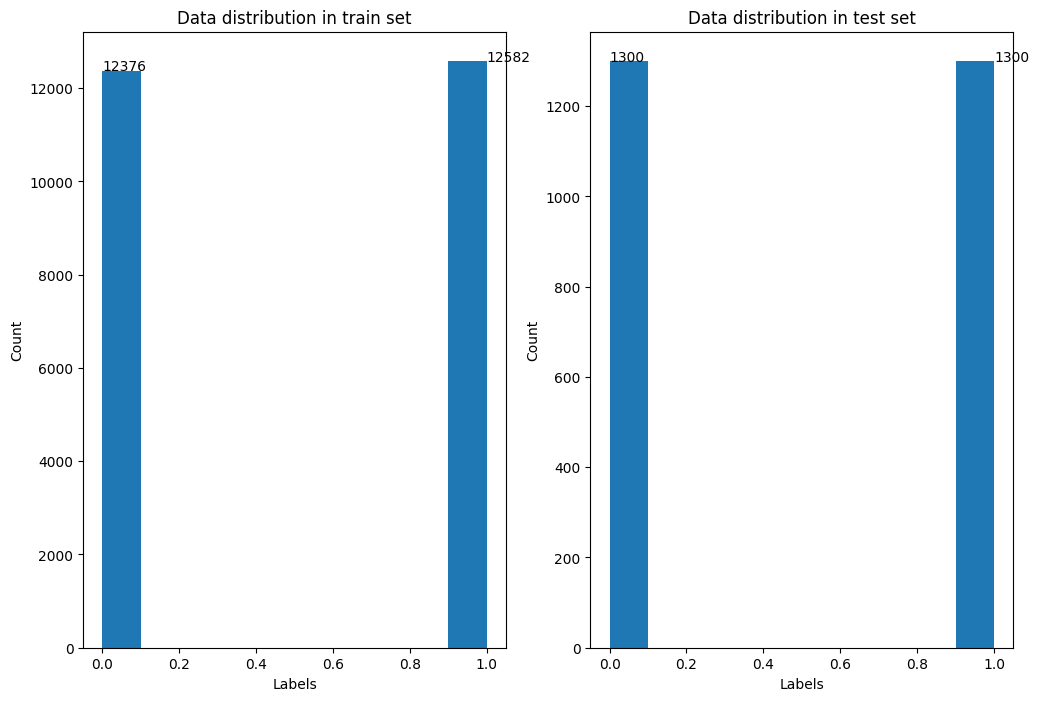

In [ ]:
# Check the data distribution in train and test set
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
plt.hist(train_labels)
plt.text(0, np.count_nonzero(train_labels == 0), np.count_nonzero(train_labels == 0))
plt.text(1, np.count_nonzero(train_labels == 1), np.count_nonzero(train_labels == 1))
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Data distribution in train set")

plt.subplot(1, 2, 2)
plt.hist(test_labels)
plt.text(0, np.count_nonzero(test_labels == 0), np.count_nonzero(test_labels == 0))
plt.text(1, np.count_nonzero(test_labels == 1), np.count_nonzero(test_labels == 1))
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Data distribution in test set")
plt.show()

<b>Observations and insights:</b>

The dataset is balanced with approximately equal number of parasitized and uninfected images in both train and test sets.

###<b> Visualize random images</b>

In [ ]:
# define the function to visualize images
def viewImages(images, labels, seed=0, figsize=12, pics=36):
  np.random.seed(seed)
  plt.figure(figsize=(figsize, figsize))

  for i in range(1, pics+1):
    plt.subplot(6, 6, i)
    index = int(np.random.randint(0, images.shape[0] + 1, 1))

    if labels[index] == 1:
      plt.title("parasitized")
    else:
      plt.title("uninfected")

    plt.imshow(images[index])
    plt.axis("off")

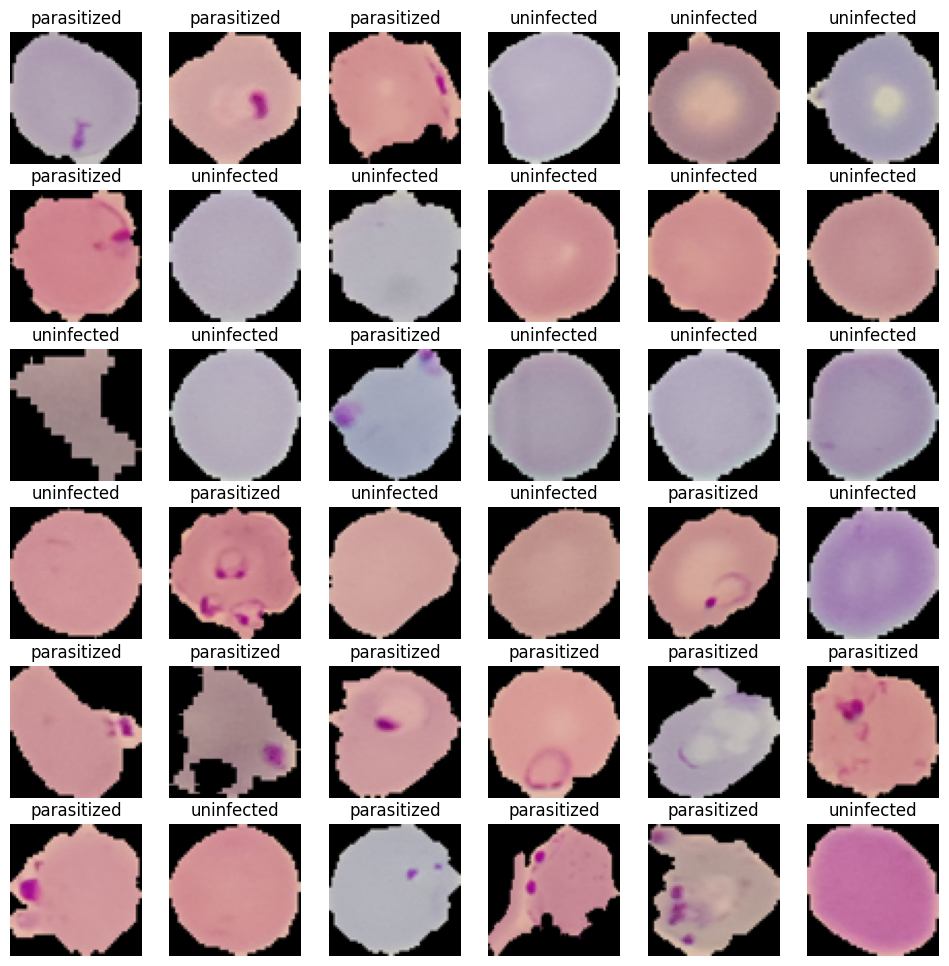

In [ ]:
# review random train images
viewImages(train_images, train_labels)

<b>Observations and insights:</b>
- After checking on more images, we observed that seemingly there is no clear distinction in the shape of cells between parasitized and uninfected.
- Cells can presented in red or purple in both parasitized and uninfected cells.
- The size of cells looks similar.
- The major visual distinction is that parasitized cells contain dark purple spots in the cytoplasm while uninfected cells have clear cytoplasm.

###<b>Plotting the mean images for parasitized and uninfected</b>

In [ ]:
# Separate parasitized and uninfected images in train data
parasitized_img = []
uninfected_img = []

for image, label in zip(train_images, train_labels):
  if label == 1:
    parasitized_img.append(image)
  else:
    uninfected_img.append(image)

In [ ]:
def plotMeanImage(img, title):
  plt.figure(figsize=(5, 5))
  plt.title(title)
  plt.imshow(img)
  plt.axis("off")

<b>Mean image for parasitized:</b>

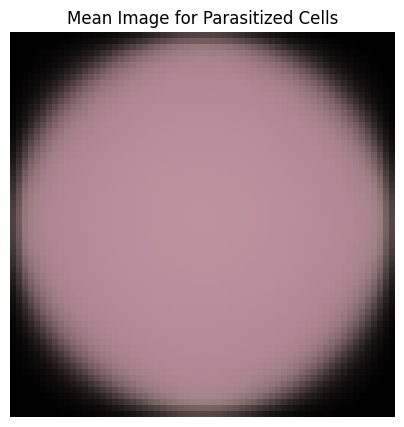

In [ ]:
# Plot the mean image for parasitized cells
mean_img_parasitized = np.mean(np.array(parasitized_img), axis=0)
plotMeanImage(mean_img_parasitized, "Mean Image for Parasitized Cells")

<b>Mean image for uninfected:</b>

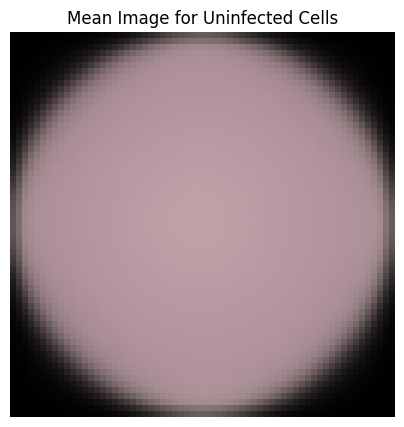

In [ ]:
# Plot the mean image for uninfected cells
mean_img_uninfected = np.mean(np.array(uninfected_img), axis=0)
plotMeanImage(mean_img_uninfected, "Mean Image for Uninfected Cells")

<b>Observations and insights:</b>

The mean arrays of parasitized and uninfected red blood cells are the same, resulting in the same mean image. We cannot use the mean values to distinguish whether a cell is parasitized.

### <b>Converting RGB to HSV of Images using OpenCV</b>

####<b> Converting the train and test data to HSV</b>

In [ ]:
# Convert array to 32 bits
train_images_32 = train_images.astype(np.float32)
test_images_32 = test_images.astype(np.float32)

In [ ]:
# define function convert RGB image to HSV
def RGBtoHSV(images):
  hsv_images = []
  for i in np.arange(len(images)):
    hsv_img = cv2.cvtColor(images[i], cv2.COLOR_RGB2HSV)
    hsv_images.append(hsv_img)
  return np.array(hsv_images)

In [ ]:
# Convert RGB to HSV
hsv_train_images = RGBtoHSV(train_images_32)
hsv_test_images = RGBtoHSV(test_images_32)

####<b>Review the converted images</b>

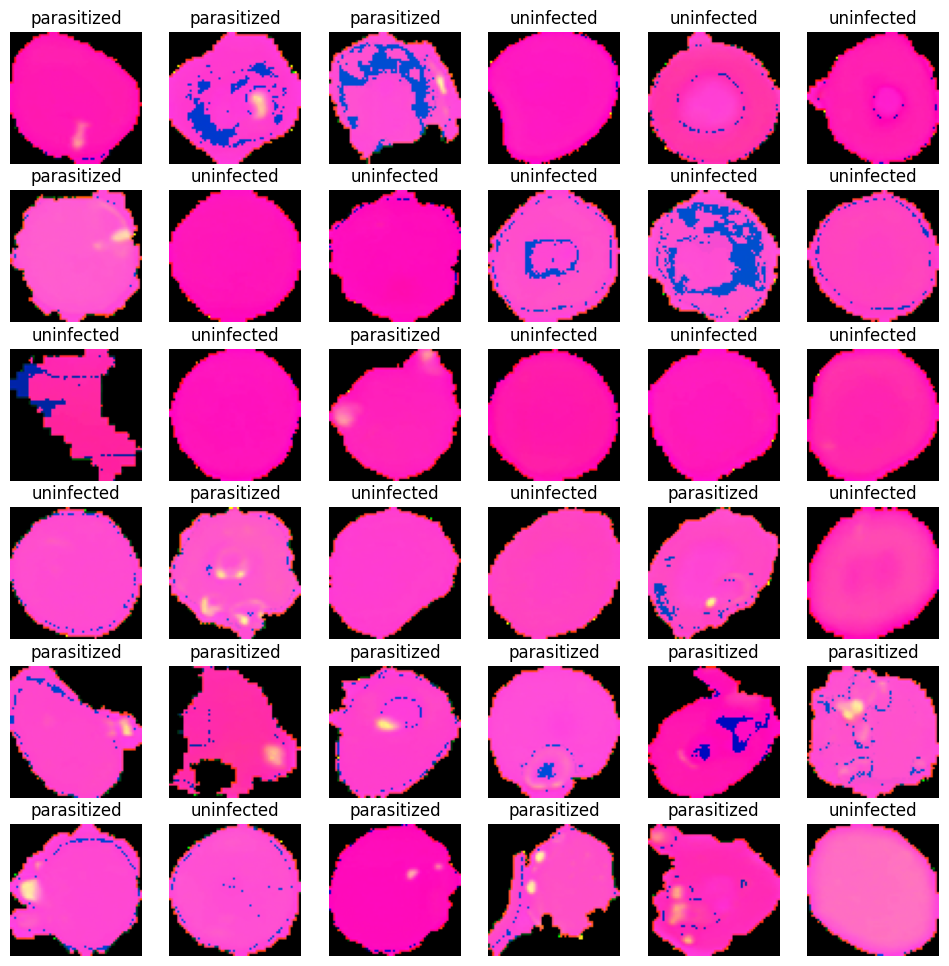

In [ ]:
viewImages(hsv_train_images, train_labels)

<b>Observations and insights:</b>

After converting to the HSV, parasitized and uninfected cell are both presented in magenta color. However, the parasitiezed cells show yellow spots in the cell area, which help us more easily identify the present of malaria.

###<b> Processing Images using Gaussian Blurring</b>

####<b>Apply Gaussian Blurring on train and test data</b>


In [ ]:
# define function to apply Gaussian Blurring
def gaussianBlur(images):
  gb_images = []

  for i in np.arange(len(images)):
    gb_img = cv2.GaussianBlur(images[i], (5, 5), 0)
    gb_images.append(gb_img)

  return np.array(gb_images)

In [ ]:
# apply Gaussian Blurring on train and test data
gb_train_images = gaussianBlur(train_images)
gb_test_images = gaussianBlur(test_images)

####<b>Review the converted images</b>

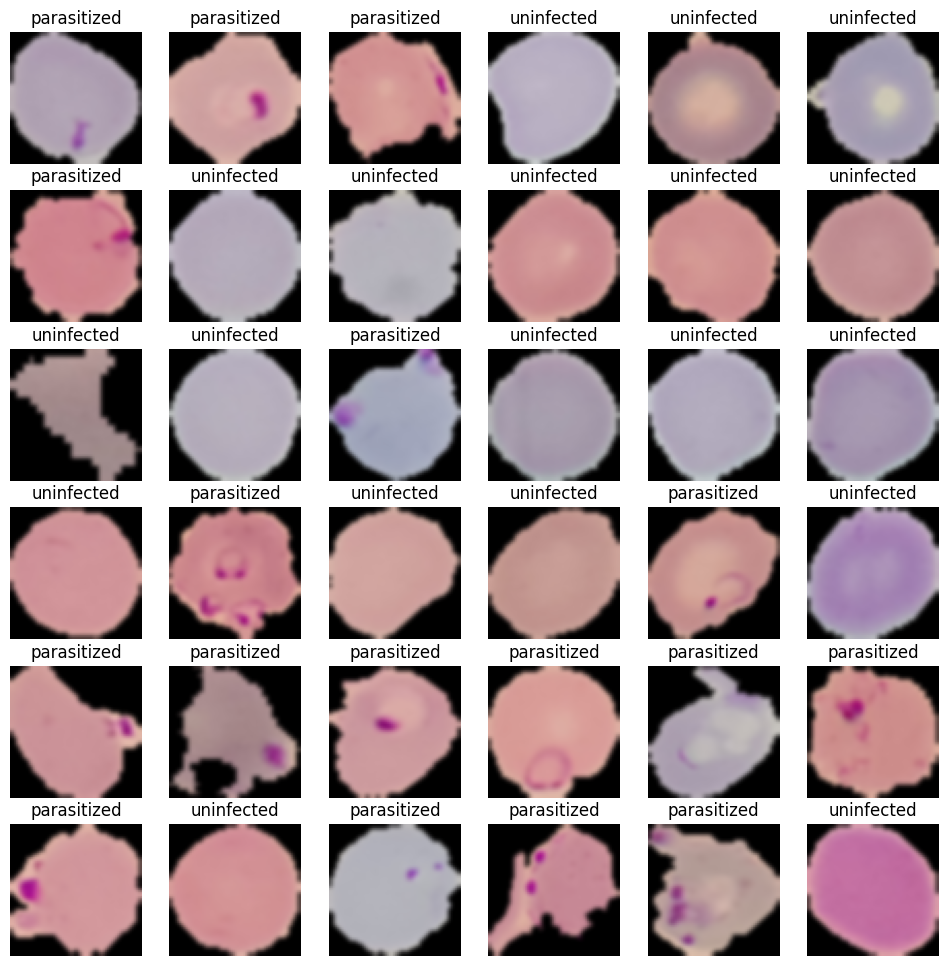

In [ ]:
# show train images after applying Gaussian Blur filter
viewImages(gb_train_images, train_labels)

<b>Observations and insights:</b>

We applied Gaussian Blur with a kernel size of (5, 5) and a standard deviation of 0. The resulted images do not enhance the visual distinction compared to the original images. Gaussian blurring would not help for this problem statement, since the filter reduce the image detail and make it harder to distinguish.


##<b>Model Building</b>

####<b>One Hot Encoding the train and test labels</b>

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
# Encode the train labels
encoded_train = encoder.fit_transform(train_labels.reshape(len(train_labels), 1))
# Encode the test labels
encoded_test = encoder.fit_transform(test_labels.reshape(len(test_labels), 1))

###<b>Model 1: AlexNet Architecture</b>

The AlexNet architecture contains eight layers, the first five are convolutional layers and the remaining three are fully connected layers. Local response normalization layers follow the first and second convolutional layers (see below). The first, second, and fifth convolutional output are fed to overlapping pooling layers. The final output is fed to a two way softmax which produces a distribution over the two class labels.

The LRN is calculated as: <br>

$b_{x, y}^{i} = a_{x, y}^{i}/(k + α \sum_{j=max(0,i-n/2)}^{min(N-1,i+n/2)} (a_{x, y}^{j})^{2})^{β}$

$a_{x,y}^{i}$ is the activity of a neuron computed by applying kernel $i$ at position $(x, y)$, $b_{x,y}^{i}$ is the response-normalized activity.

####<b>Building the model</b>

In [ ]:
# Creating a AlexNet model
def build_AlexNet():
  model = tf.keras.Sequential(
      [
          tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding="same", activation="relu", input_shape=(64, 64, 3)),
          tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, bias=2, alpha=1e-4, beta=0.75)),
          tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

          tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding="same", activation="relu"),
          tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, bias=2, alpha=1e-4, beta=0.75)),
          tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

          tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"),

          tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"),

          tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

          tf.keras.layers.Flatten(),

          tf.keras.layers.Dense(4096, activation="relu"),
          tf.keras.layers.Dropout(0.5),

          tf.keras.layers.Dense(4096, activation="relu"),
          tf.keras.layers.Dropout(0.5),

          tf.keras.layers.Dense(2, activation="softmax")

      ]
  )
  return model

In [ ]:
model_1 = build_AlexNet()

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 16, 16, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 96)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         614656    
                                                                 
 lambda_1 (Lambda)           (None, 7, 7, 256)         0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 256)         0         
 g2D)                                                   

####<b>Compiling the model</b>

In [ ]:
model_1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, weight_decay=5e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True)

<b>Fit and train the Model - RGB images</b>

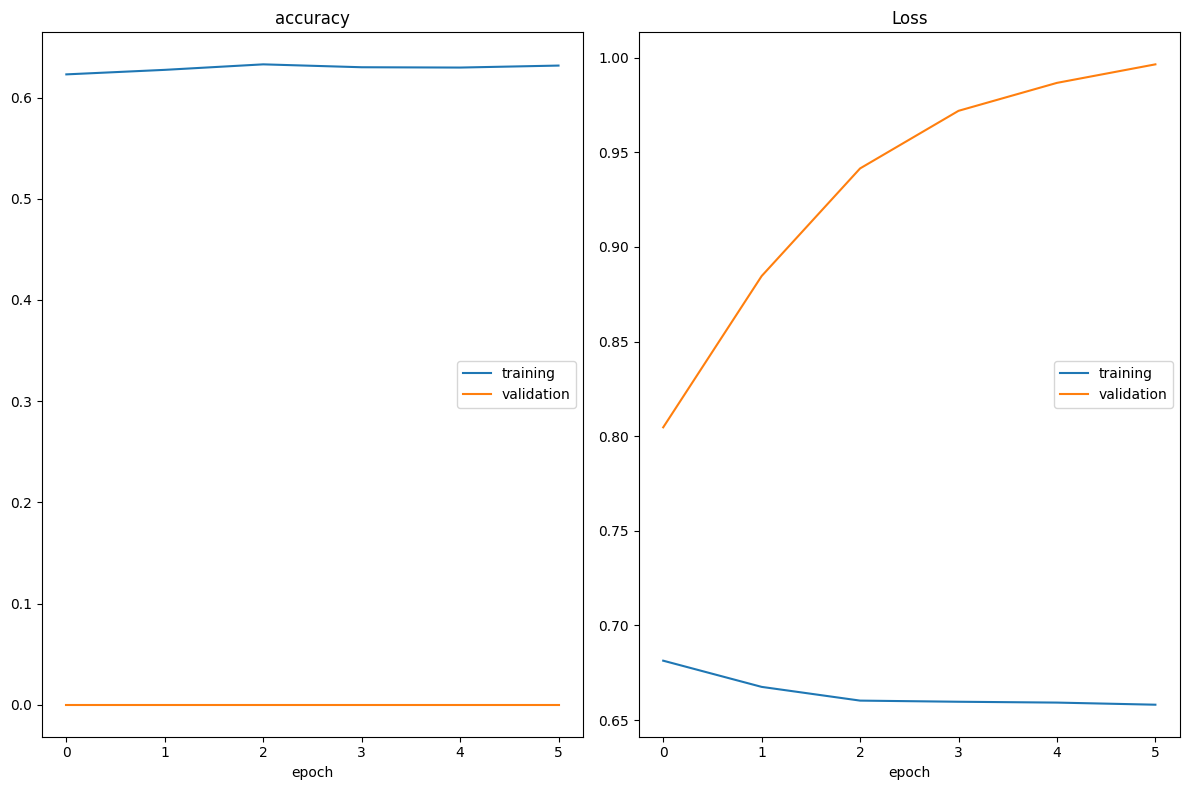

accuracy
	training         	 (min:    0.623, max:    0.633, cur:    0.632)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.658, max:    0.681, cur:    0.658)
	validation       	 (min:    0.805, max:    0.997, cur:    0.997)
194/194 [==============================] - 3s 17ms/step - loss: 0.6581 - accuracy: 0.6316 - val_loss: 0.9965 - val_accuracy: 0.0000e+00


In [ ]:
# Fit the model on the RGB image data
history_model_1_rgb = model_1.fit(
    train_images,
    encoded_train,
    epochs=20,
    validation_split=0.2,
    batch_size=128,
    steps_per_epoch=len(train_images)//128,
    callbacks=[early_stopping, PlotLossesKeras()],
    verbose=1
)

####<b>Model Evaluation</b>

In [ ]:
# Evaluate the RGB model on test set
evaluate_test_rgb = model_1.evaluate(test_images, encoded_test, verbose=1)

print("Loss value:", evaluate_test_rgb[0])
print("Accuarcy:", evaluate_test_rgb[1])

82/82 [==============================] - 1s 4ms/step - loss: 0.6988 - accuracy: 0.5000
Loss value: 0.6987641453742981
Accuarcy: 0.5


<b>Plotting the confusion matrix</b>

In [ ]:
# define prediction function
def prediction(model, dataset, labels):
  pred = model.predict(dataset)
  pred = np.argmax(pred, axis=-1)
  actual = np.argmax(labels, axis=-1)
  return (actual, pred)

In [ ]:
actual_model_1_rgb, pred_model_1_rgb = prediction(model_1, test_images, encoded_test)

82/82 [==============================] - 0s 2ms/step


In [ ]:
# Define the function for classification report and confusion matrix
def ModelPerformance(actual, pred):
  print(classification_report(actual, pred))

  cm = confusion_matrix(actual, pred)

  plt.figure(figsize=(8, 5))
  sns.heatmap(cm, annot=True, fmt=".0f")
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1300
           1       0.50      1.00      0.67      1300

    accuracy                           0.50      2600
   macro avg       0.25      0.50      0.33      2600
weighted avg       0.25      0.50      0.33      2600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


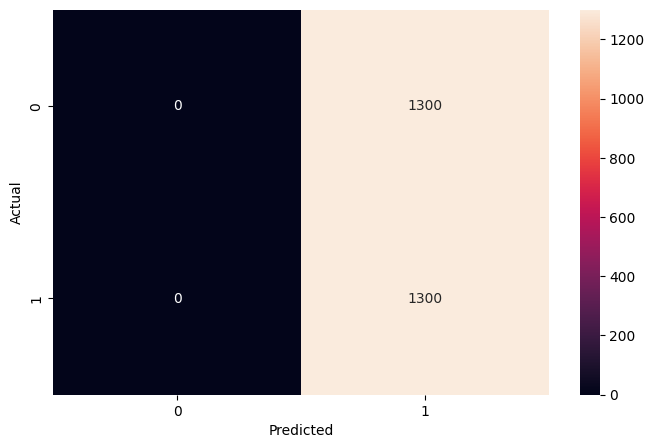

In [ ]:
# Examine the performance of model on RGB images
ModelPerformance(actual_model_1_rgb, pred_model_1_rgb)

<b>Observations:</b>

- The base AlexNet model train on RGB images quickly converged without learning the features, as all images are predicted as parasitized.

#####<b>Test the CNN model performance on HSV images</b>

In [ ]:
# Clear the backend
tf.keras.backend.clear_session()

<b>Fit and train our Model - HSV images</b>

In [ ]:
model_1_hsv = build_AlexNet()

In [ ]:
model_1_hsv.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, weight_decay=5e-4), loss="binary_crossentropy", metrics=["accuracy"])

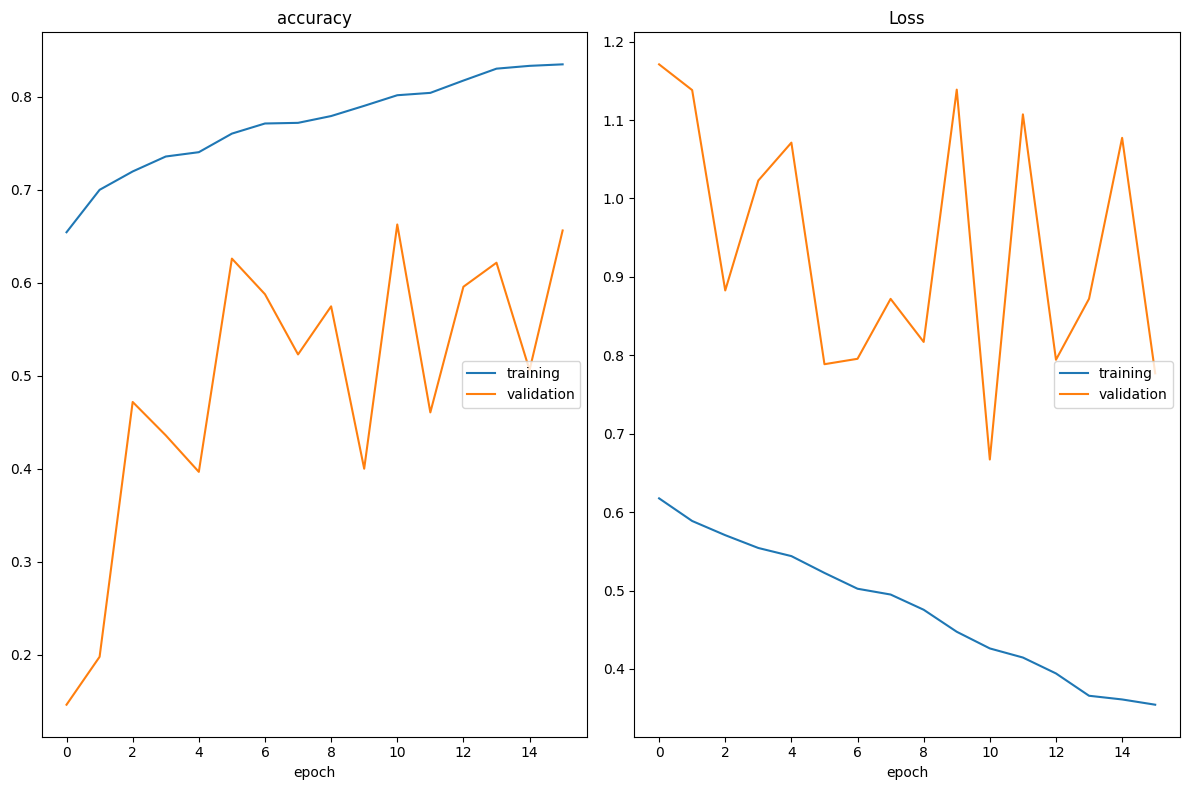

accuracy
	training         	 (min:    0.654, max:    0.835, cur:    0.835)
	validation       	 (min:    0.146, max:    0.662, cur:    0.656)
Loss
	training         	 (min:    0.354, max:    0.618, cur:    0.354)
	validation       	 (min:    0.667, max:    1.171, cur:    0.777)
194/194 [==============================] - 3s 17ms/step - loss: 0.3544 - accuracy: 0.8346 - val_loss: 0.7770 - val_accuracy: 0.6560


In [ ]:
# Fit the model on the HSV image data
history_model_1_hsv = model_1_hsv.fit(
    hsv_train_images,
    encoded_train,
    epochs=20,
    validation_split=0.2,
    batch_size=128,
    steps_per_epoch=len(hsv_train_images)//128,
    callbacks=[early_stopping, PlotLossesKeras()],
    verbose=1
)

<b>Model Evaluation</b>

In [ ]:
# Evaluate the HSV model on test set
evaluate_test_hsv = model_1_hsv.evaluate(hsv_test_images, encoded_test, verbose=1)

print("Loss value:", evaluate_test_hsv[0])
print("Accuarcy:", evaluate_test_hsv[1])

82/82 [==============================] - 0s 4ms/step - loss: 0.5834 - accuracy: 0.7185
Loss value: 0.5834031701087952
Accuarcy: 0.7184615135192871


<b>Plotting the confusion matrix</b>

In [ ]:
actual_model_1_hsv, pred_model_1_hsv = prediction(model_1_hsv, hsv_test_images, encoded_test)

82/82 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

           0       0.78      0.61      0.68      1300
           1       0.68      0.83      0.75      1300

    accuracy                           0.72      2600
   macro avg       0.73      0.72      0.72      2600
weighted avg       0.73      0.72      0.72      2600



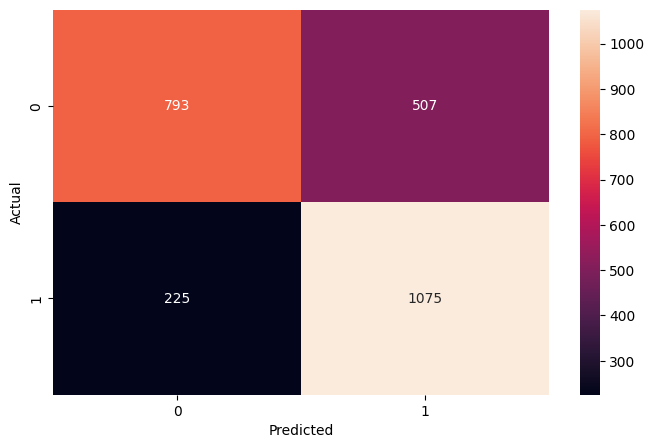

In [ ]:
# Examine the performance of the model on HSV images
ModelPerformance(actual_model_1_hsv, pred_model_1_hsv)

**Summary:** <br>
- We trained the base AlexNet model on RGB images and HSV images respectively.
- During the training process, model training on RGB images failed to extract the features and converged quickly. Model trained on HSV images gave 72% accuracy and 61% recall in classifying uninfected cells in test set.
- The HSV input gives our model better performance in classification compared to training on RGB images.

###<b>Applying Data Augmentation</b>
We artificially enlarge our dataset to train on and reduce overfitting by using data augmentation. The forms of data augmentation consists of horizontal and vertical reflection, rotation, shearing and zooming.

####<b> Use image data generator</b>

In [ ]:
# Create ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=180,
    shear_range=0.1,
    zoom_range=0.2,
    validation_split=0.2
)

####<B>Visualize augmented images

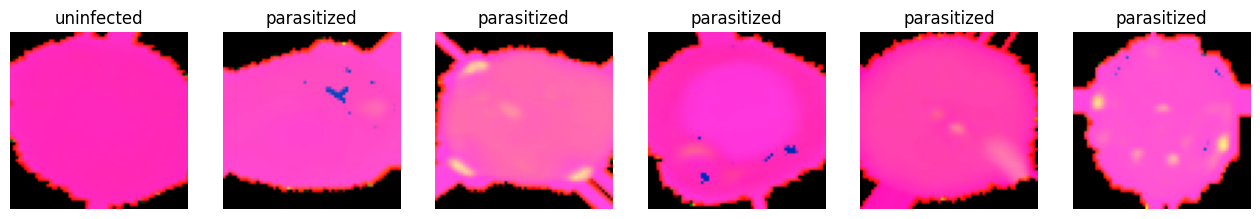

In [ ]:
# Flow train images into generator
generator = datagen.flow(hsv_train_images, encoded_train, batch_size=32, seed=0, shuffle=True)

imgs, labels = next(generator)

fig, axes = plt.subplots(1, 6, figsize=(16, 8))
fig.set_size_inches(16, 16)

for (img, label, ax) in zip(imgs, labels, axes.flatten()):
  ax.imshow(img)
  if label[1] == 1:
    ax.set_title("parasitized")
  else:
    ax.set_title("uninfected")
  ax.axis("off")

<b>Observations and insights:</b>
- Data augmentation generating images with horizontal flip, vertical flip, 360 degree rotation, shear transformation, and zooming.
- The shapes of cells are more varing and this should help our model in preventing capture of this feature, since the shape of cells is irrelevant to classify whether the cell is parasitized.
- The parasitized cells shows dark spots and can be clearly identified.

###<b>Fine tune hyperparameters<b/>

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# define function for model building and tuning
def build_AlexNet(hp):
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding="same", activation="relu", input_shape=(64, 64, 3)))
  pool_size = hp.Choice("pool_sizes", [2, 3])    # tune pooling size in max pooling
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size), strides=(2, 2)))
  model.add(tf.keras.layers.BatchNormalization())    # use Batch Normalization instead of LRN

  model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding="same", activation="relu"))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size), strides=(2, 2)))
  model.add(tf.keras.layers.BatchNormalization())    # use Batch Normalization instead of LRN

  model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"))
  model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"))
  model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size), strides=(2, 2)))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(units=hp.Int("units_1", min_value=256, max_value=4096, step=256), activation="relu"))    # tune number of units
  # add dropout or not
  if hp.Boolean("dropout_1"):
    model.add(tf.keras.layers.Dropout(rate=hp.Float("dp_rate_1", min_value=0.25, max_value=0.5)))    # tune dropout rate

  model.add(tf.keras.layers.Dense(units=hp.Int("units_2", min_value=256, max_value=4096, step=256), activation="relu"))    # tune number of units

  if hp.Boolean("dropout_2"):
    model.add(tf.keras.layers.Dropout(rate=hp.Float("dp_rate_2", min_value=0.25, max_value=0.5))) # tune dropout rate

  model.add(tf.keras.layers.Dense(2, activation="softmax"))

  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")    # tune learning rate
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, weight_decay=5e-4), loss="binary_crossentropy", metrics=["accuracy"])

  return model

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_AlexNet,
    max_trials=20,
    objective="val_accuracy",
    executions_per_trial=3,
    overwrite=True
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
pool_sizes (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 4096, 'step': 256, 'sampling': 'linear'}
dropout_1 (Boolean)
{'default': False, 'conditions': []}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 4096, 'step': 256, 'sampling': 'linear'}
dropout_2 (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
# grid search defined hyperparameters
tuner.search(
    datagen.flow(hsv_train_images, encoded_train, batch_size=32, subset="training"),
    validation_data=datagen.flow(hsv_train_images, encoded_train, batch_size=8, subset="validation"),
    epochs=20,
    callbacks=[early_stopping]
)

Trial 20 Complete [00h 25m 15s]
val_accuracy: 0.8907366593678793

Best val_accuracy So Far: 0.948707660039266
Total elapsed time: 05h 39m 02s


In [ ]:
# review the tuning result
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 15 summary
Hyperparameters:
pool_sizes: 3
units_1: 1792
dropout_1: True
units_2: 2560
dropout_2: True
lr: 0.009287959309973642
dp_rate_1: 0.39203384972595556
dp_rate_2: 0.2602346859871699
Score: 0.948707660039266

Trial 05 summary
Hyperparameters:
pool_sizes: 3
units_1: 768
dropout_1: True
units_2: 2560
dropout_2: False
lr: 0.00722950058177687
dp_rate_1: 0.39530597442694476
dp_rate_2: 0.27552446159675065
Score: 0.9412943124771118

Trial 16 summary
Hyperparameters:
pool_sizes: 3
units_1: 2048
dropout_1: False
units_2: 3840
dropout_2: True
lr: 0.008999594578896777
dp_rate_1: 0.2680089578480176
dp_rate_2: 0.34831136648888256
Score: 0.924931546052297

Trial 12 summary
Hyperparameters:
pool_sizes: 3
units_1: 4096
dropout_1: False
units_2: 2560
dropout_2: False
lr: 0.004370656829970498
dp_rate_1: 0.456879937704776
dp_rate_2: 0.34332808715932833
Score: 0.9022908012072245

In [ ]:
# get the hyperparameters
best_hps = tuner.get_best_hyperparameters()

# build the model based on the best hyperparameters
model_1_best = tuner.hypermodel.build(best_hps[0])
model_1_best.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 96)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 7, 7, 96)          384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 256)         0         
 g2D)                                                            
                                                        

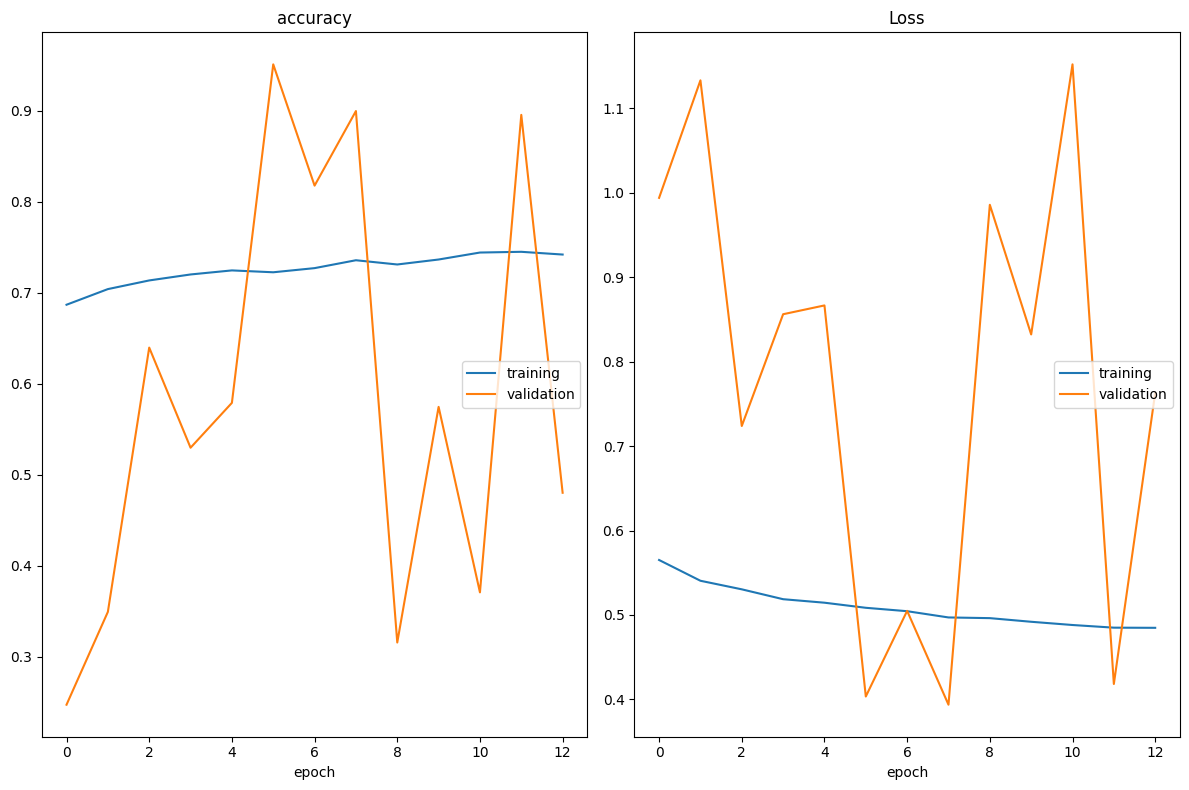

accuracy
	training         	 (min:    0.687, max:    0.745, cur:    0.742)
	validation       	 (min:    0.247, max:    0.951, cur:    0.480)
Loss
	training         	 (min:    0.485, max:    0.565, cur:    0.485)
	validation       	 (min:    0.394, max:    1.152, cur:    0.763)
624/624 [==============================] - 25s 41ms/step - loss: 0.4848 - accuracy: 0.7420 - val_loss: 0.7628 - val_accuracy: 0.4803


In [ ]:
# fit the model
model_1_best_history = model_1_best.fit(
    datagen.flow(hsv_train_images, encoded_train, batch_size=32, subset="training"),
    validation_data=datagen.flow(hsv_train_images, encoded_train, batch_size=8, subset="validation"),
    epochs=20,
    callbacks=[early_stopping, PlotLossesKeras()],
    verbose=1
)

####<b>Model Evaluation<b/>

In [ ]:
evaluate_model = model_1_best.evaluate(hsv_test_images, encoded_test, verbose=1)

print("Loss value:", evaluate_model[0])
print("Accuarcy:", evaluate_model[1])

82/82 [==============================] - 0s 3ms/step - loss: 0.5976 - accuracy: 0.6919
Loss value: 0.5976204872131348
Accuarcy: 0.6919230818748474


In [ ]:
actual_model_1, pred_model_1 = prediction(model_1_best, hsv_test_images, encoded_test)

82/82 [==============================] - 1s 2ms/step


              precision    recall  f1-score   support

           0       0.75      0.57      0.65      1300
           1       0.65      0.82      0.73      1300

    accuracy                           0.69      2600
   macro avg       0.70      0.69      0.69      2600
weighted avg       0.70      0.69      0.69      2600



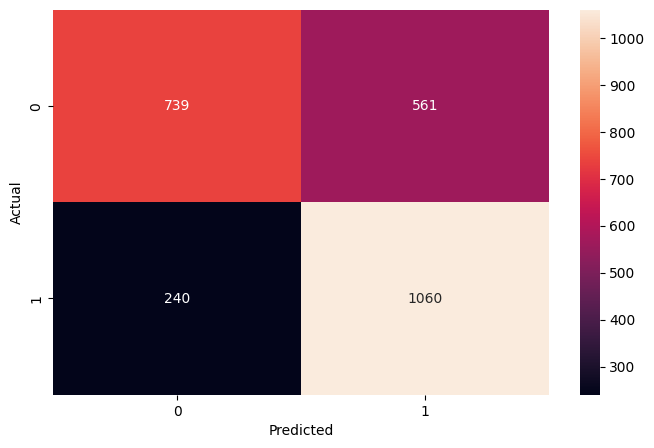

In [ ]:
# Examine the performance of the model
ModelPerformance(actual_model_1, pred_model_1)

####<b>Observation</b>
The overall accuracy of fine tuned model 1 is 69%, the performance is similar compared to our previous model.

### <b>Model 2: Transfer Learning with VGG-16</b>
VGG-16 is a convolutional neural network trained on a subset of the ImageNet dataset, which consists of 1.2 million images to classify  1000 different categories. We can harness a pre-trained model in image classification by applying transfer learning.

####<b>Building the Model</b>

In [ ]:
# Clear the backend
tf.keras.backend.clear_session()

In [ ]:
# Only preserve the convolutional and pooling layers
model_vgg = VGG16(include_top=False, weights="imagenet", input_shape=(64, 64, 3))

model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
# define model tuning function
def tuneModel(model, fine_tune=0):
  if fine_tune > 0:
    for layer in model.layers[:-fine_tune]:
      layer.trainable = False
  else:
    for layer in model.layers:
      layer.trainable = False

In [ ]:
# define model
def build_VGG(hp):
  VGG_model = tf.keras.Sequential()

  tuneModel(model_vgg, hp.Int("fine_tune", min_value=0, max_value=5, step=1))

  VGG_model.add(model_vgg)

  VGG_model.add(tf.keras.layers.BatchNormalization())

  VGG_model.add(tf.keras.layers.Flatten())

  VGG_model.add(tf.keras.layers.Dense(units=hp.Int("units_a", min_value=256, max_value=4096, step=256), activation="relu"))

  if hp.Boolean("dropout_a"):
    VGG_model.add(tf.keras.layers.Dropout(rate=hp.Float("dp_rate_a", min_value=0.25, max_value=0.5)))

  VGG_model.add(tf.keras.layers.Dense(units=hp.Int("units_b", min_value=256, max_value=4096, step=256), activation="relu"))

  if hp.Boolean("dropout_b"):
    VGG_model.add(tf.keras.layers.Dropout(rate=hp.Float("dp_rate_b", min_value=0.25, max_value=0.5)))

  VGG_model.add(tf.keras.layers.Dense(2, activation="softmax"))

  learning_rate = hp.Float("lr_vgg", min_value=1e-4, max_value=1e-2, sampling="log")
  VGG_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, weight_decay=5e-4), loss="binary_crossentropy", metrics=["accuracy"])

  return VGG_model

In [ ]:
# define tuner
tuner_vgg = keras_tuner.RandomSearch(
    hypermodel=build_VGG,
    max_trials=10,
    objective="val_accuracy",
    executions_per_trial=2,
    overwrite=True
)

In [ ]:
tuner_vgg.search_space_summary()

Search space summary
Default search space size: 6
fine_tune (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_a (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 4096, 'step': 256, 'sampling': 'linear'}
dropout_a (Boolean)
{'default': False, 'conditions': []}
units_b (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 4096, 'step': 256, 'sampling': 'linear'}
dropout_b (Boolean)
{'default': False, 'conditions': []}
lr_vgg (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
# grid search hyperparameters
tuner_vgg.search(
    datagen.flow(hsv_train_images, encoded_train, batch_size=32, subset="training"),
    validation_data=datagen.flow(hsv_train_images, encoded_train, batch_size=8, subset="validation"),
    epochs=20,
    callbacks=[early_stopping]
)

Trial 10 Complete [00h 10m 16s]
val_accuracy: 0.6526748239994049

Best val_accuracy So Far: 0.6974554359912872
Total elapsed time: 01h 38m 13s


In [ ]:
# review the tuning result
tuner_vgg.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
fine_tune: 4
units_a: 3584
dropout_a: False
units_b: 256
dropout_b: True
lr_vgg: 0.008440052458138132
dp_rate_a: 0.3691062686823761
dp_rate_b: 0.25
Score: 0.6974554359912872

Trial 06 summary
Hyperparameters:
fine_tune: 0
units_a: 1536
dropout_a: True
units_b: 2304
dropout_b: True
lr_vgg: 0.007216386468332445
dp_rate_a: 0.26870512610942027
dp_rate_b: 0.4300163956804547
Score: 0.686736136674881

Trial 04 summary
Hyperparameters:
fine_tune: 3
units_a: 256
dropout_a: True
units_b: 1280
dropout_b: True
lr_vgg: 0.009575093678226607
dp_rate_a: 0.33098029145564534
dp_rate_b: 0.46762511560136305
Score: 0.6635944545269012

Trial 05 summary
Hyperparameters:
fine_tune: 2
units_a: 256
dropout_a: True
units_b: 3328
dropout_b: False
lr_vgg: 0.0006773981501812385
dp_rate_a: 0.383554782346356
dp_rate_b: 0.46508249436487825
Score: 0.6621919572353363

Tr

In [ ]:
# get the hyperparameters
best_hps_vgg = tuner_vgg.get_best_hyperparameters()

# build the model based on the best hyperparameters
model_2_best = tuner_vgg.hypermodel.build(best_hps[0])
model_2_best.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 2, 2, 512)         2048      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                        

<b>Fit and train the model</b>

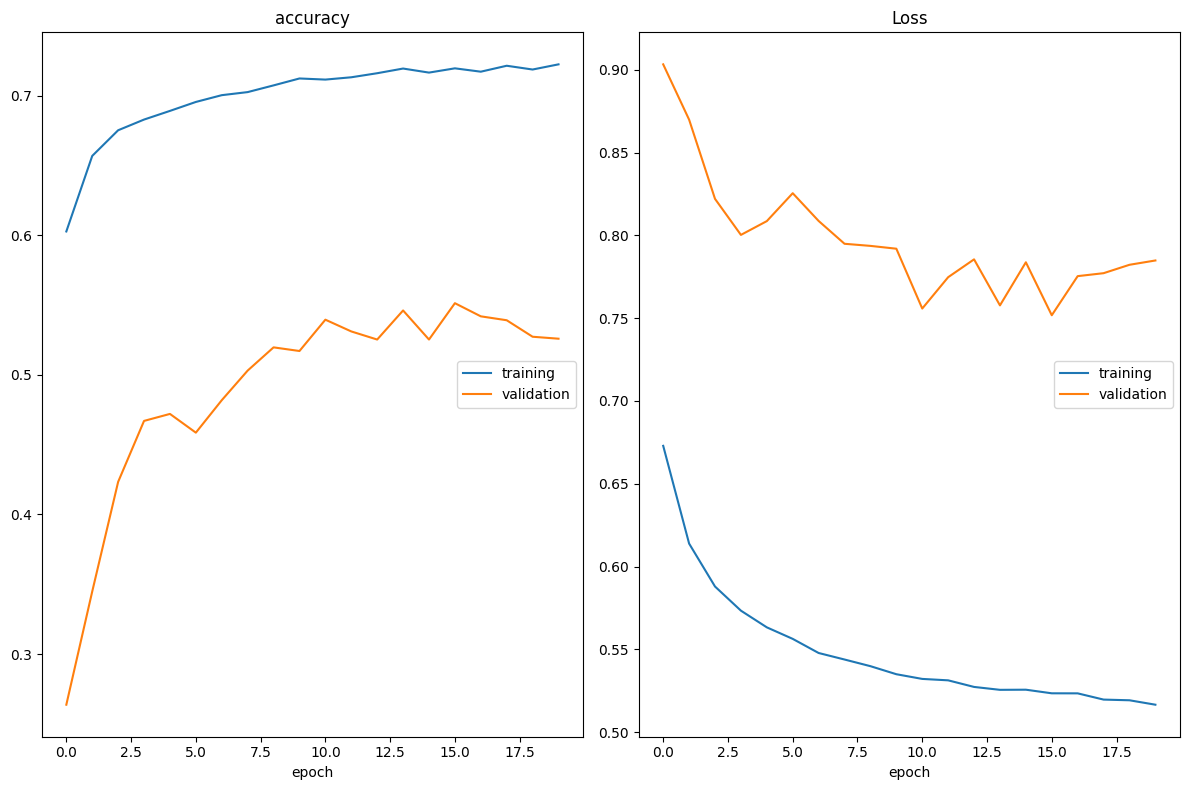

accuracy
	training         	 (min:    0.603, max:    0.723, cur:    0.723)
	validation       	 (min:    0.264, max:    0.551, cur:    0.526)
Loss
	training         	 (min:    0.517, max:    0.673, cur:    0.517)
	validation       	 (min:    0.752, max:    0.903, cur:    0.785)
624/624 [==============================] - 26s 42ms/step - loss: 0.5166 - accuracy: 0.7225 - val_loss: 0.7849 - val_accuracy: 0.5259


In [ ]:
# Fit the VGG model
VGG_history = model_2_best.fit(
    datagen.flow(hsv_train_images, encoded_train, batch_size=32, subset="training"),
    validation_data=datagen.flow(hsv_train_images, encoded_train, batch_size=8, subset="validation"),
    epochs=20,
    callbacks=[early_stopping, PlotLossesKeras()],
    verbose=1
)

####<b>Model Evaluation</b>

In [ ]:
# Evaluate the VGG model on test set
evaluate_test_VGG = model_2_best.evaluate(hsv_test_images, encoded_test, verbose=1)

print("Loss value:", evaluate_test_VGG[0])
print("Accuaracy:", evaluate_test_VGG[1])

82/82 [==============================] - 1s 6ms/step - loss: 0.5467 - accuracy: 0.6900
Loss value: 0.546707808971405
Accuaracy: 0.6899999976158142


<b>Plotting the classification report and confusion matrix</b>

82/82 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1300
           1       0.71      0.65      0.68      1300

    accuracy                           0.69      2600
   macro avg       0.69      0.69      0.69      2600
weighted avg       0.69      0.69      0.69      2600



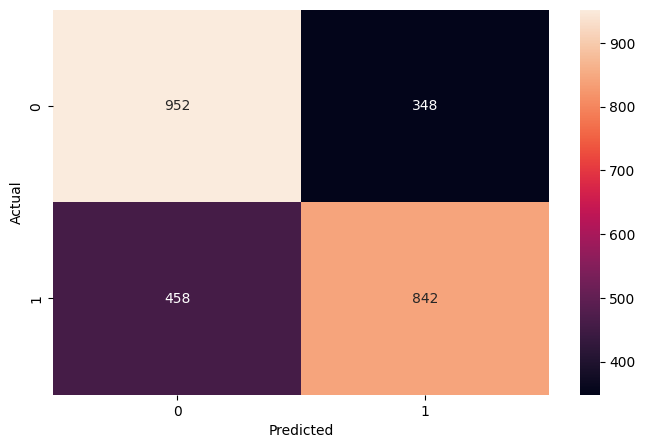

In [ ]:
actual_VGG, pred_VGG = prediction(model_2_best, hsv_test_images, encoded_test)

ModelPerformance(actual_VGG, pred_VGG)

<b>Observations:</b>
- The VGG-16 model gives a similar overall accuracy of 69%, but with better recall of 73% of uninfected cells.

###<b>Model 3: Custom model</b>

Both AlexNet and VGG-16 did not give a considerably good accuracy in prediction. Now, we try to model a solution with a simpler architecture. The new model will contains only three convolutional layers and each follow by a max pooling layer with equal stirdes. Then the convolutional output is fed to two fully connected layers.

#### Building the model

In [ ]:
# clear backend
tf.keras.backend.clear_session()

In [ ]:
# build a custom model
def build_custom():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(64, 64, 3)))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(512, activation="relu"))

  model.add(tf.keras.layers.Dense(2, activation="softmax"))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
model_3 = build_custom()
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 64)          0

#### Model fitting

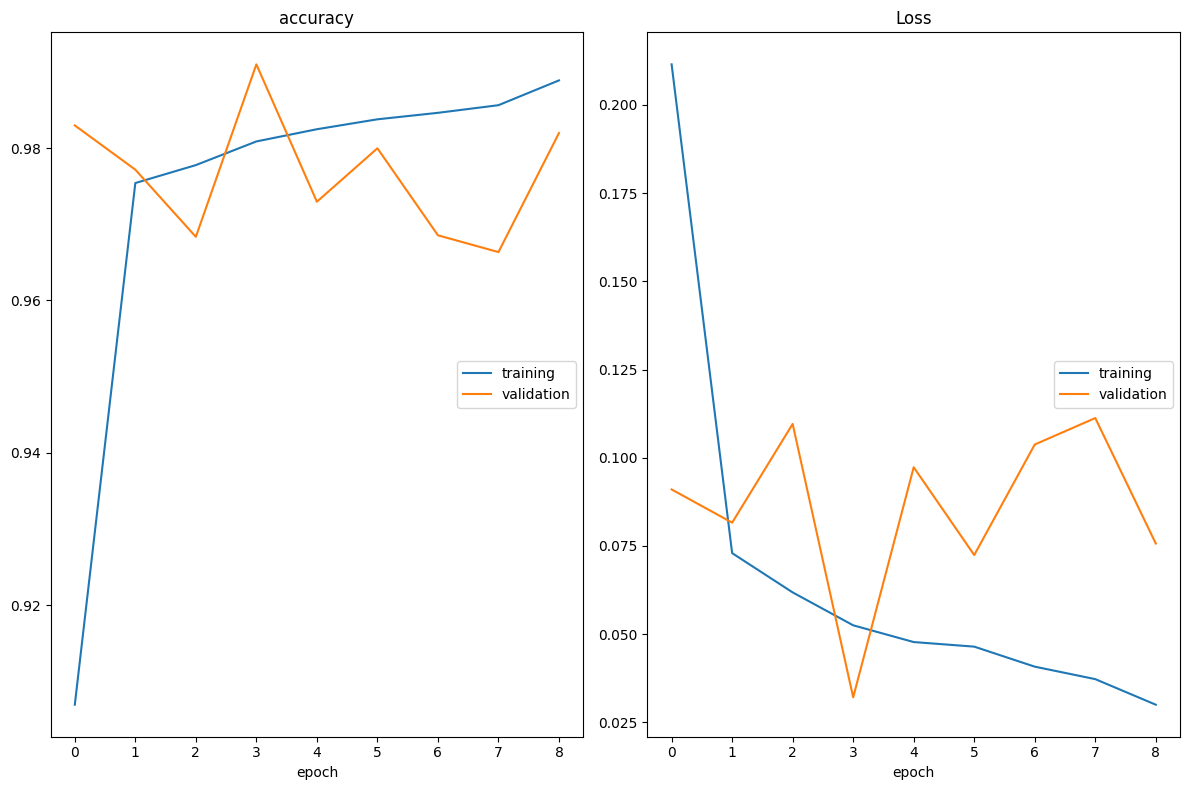

accuracy
	training         	 (min:    0.907, max:    0.989, cur:    0.989)
	validation       	 (min:    0.966, max:    0.991, cur:    0.982)
Loss
	training         	 (min:    0.030, max:    0.212, cur:    0.030)
	validation       	 (min:    0.032, max:    0.111, cur:    0.076)
624/624 [==============================] - 3s 6ms/step - loss: 0.0300 - accuracy: 0.9889 - val_loss: 0.0757 - val_accuracy: 0.9820


In [ ]:
# Fitting model 3
history_model_3 = model_3.fit(
    train_images,
    encoded_train,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stopping, PlotLossesKeras()],
    verbose=1
)

#### Model Evaluation

In [ ]:
evaluate_model_3 = model_3.evaluate(test_images, encoded_test, verbose=1)

print("Loss value:", evaluate_model_3[0])
print("Accuarcy:", evaluate_model_3[1])

82/82 [==============================] - 0s 3ms/step - loss: 0.0437 - accuracy: 0.9862
Loss value: 0.04372934624552727
Accuarcy: 0.9861538410186768


In [ ]:
actual_model_3, pred_model_3 = prediction(model_3, test_images, encoded_test)

82/82 [==============================] - 0s 2ms/step


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1300
           1       0.99      0.98      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



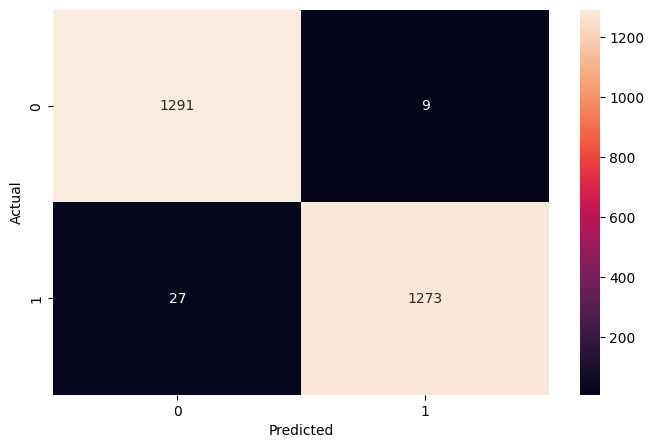

In [ ]:
ModelPerformance(actual_model_3, pred_model_3)

##<b>Summary</b>
After heuristic search, we construct a custom model with five layers, consists of three convolutional layers and each following by a 2x2 max pooling, and two fully connected layers. Using Adam instead of stochastic gradient descent as the optimizer when compiling the model.

The model is trained on original RGB images without data augmentation.

The model gives 99% overall accuracy and 99% recall on uninfected cells, which is significantly outperform AlexNet and VGG-16 models.